In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [3]:
from google.colab import drive 
drive.mount('/content/drive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'drive/My Drive/cv/day39'
#!git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/cv/day39
/content/drive/My Drive/cv/day39/keras-yolo3


In [5]:
pwd

'/content/drive/My Drive/cv/day39/keras-yolo3'

In [4]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [0]:
import numpy as np

if not os.path.exists("train.txt"):
  
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library


  sets=['train' , 'val']

  
  classes = ["kangaroo" , "raccoon"]

  # 把 annotation 轉換訓練時需要的資料形態

  def convert_annotation(data_path, list_file):
      """
        將對應文件名的xml文件轉化為label文件，xml文件包含了對應的bounding框以及圖片長寬大小等信息，
        通過對其解析，然後進行歸一化最終讀到label文件中去，也就是說
        一張圖片文件對應一個xml文件，然後通過解析和歸一化，能夠將對應的信息保存到唯一一個label文件中去
      """
      in_file = open(data_path)
      tree=ET.parse(in_file)

      #  root 是一個指向Element的對象
      root = tree.getroot()
      # Finding interesting elements
      # 遍歷目標obj
      """
        在用find()方法找到特定的tag後，想獲取裡面的文本，可以用.text屬性或者.string屬性。
        在很多時候，兩者的返回結果一致，但其實兩者是有區别的。
        參考資料：http://zqchen90.github.io/2016/04/05/python-element-tree/
      """
      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          
          #如果類別不是對應在我們預定好的class文件中，或difficult==1則跳過
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          # Save a list/line to a .txt file
          # https://stackoverflow.com/questions/33686747/save-a-list-to-a-txt-file
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
          
      
      in_file.close()

  class_txt = open('class.txt', 'w')
  for class_id in classes : 
      class_txt.write('%s' %(class_id))
      class_txt.write('\n')
  class_txt.close()
  

  images_dir = ['kangaroo-master/images', 'raccoon_dataset-master/images']
  for set in sets:
      '''
        對所有的文件數據集進行遍歷
        做了两個工作：
　　　　１．將所有圖片文件都遍歷一遍，並且將其所有的全路徑都寫在對應的txt文件中去，方便定位
　　　　２．同時對所有的圖片文件進行解析和轉化，將其對應的bundingbox以及類别的信息全部解析寫到label文件(即train.txt和val.txt)中，
    　　　 最後再通過直接讀取文件，就能找到對應的label信息
      '''
      list_file = open('%s.txt' % set , 'w')

      for  i , annotation_path in enumerate(['kangaroo-master/annots', 'raccoon_dataset-master/annotations']):
            if os.path.exists(annotation_path):
              print('exists!')
            else:
              print('path not exist')

            # os.listdir() 方法用於返回指定的文件夾包含的文件或文件夾的名字的列表。
            annots = os.listdir(annotation_path)
            #會按照xml的檔案名稱編號排序
            annots.sort()
            annot_len = len(annots)
            split_num = int(np.round(annot_len * 0.9))

            if set == 'train':
              data = annots[:split_num]
            else:
              data = annots[split_num:]

            for id in data: 
              # 例如：在kangaroo中data是00001.jpg，name則是00001
              name = id.split('.')[0]
              list_file.write(os.path.join(images_dir[i], '%s.jpg' % name))
              convert_annotation(os.path.join(annotation_path , id), list_file)
              list_file.write('\n')

              
      list_file.close()

In [0]:
# convert.py '-w' : 代表只轉換權重 weights 到 model_data/yolo_weights.h5
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [5]:
import numpy as np
import keras.backend as K
# Lambda:Wraps arbitrary expression as a Layer object.
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

# log紀錄用，避免覆寫
import time

Using TensorFlow backend.


In [4]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

Using TensorFlow backend.


In [0]:
# https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images/23575424#23575424
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
annotation_path_train = 'train.txt' # 轉換好格式的 train 標註檔案
annotation_path_val = 'val.txt' # 轉換好格式的 val 標註檔案
log_dir = 'logs/%s/' % str(int(time.time())) # 訓練好的模型儲存的路徑
classes_path = 'class.txt'  # used only for constructing model
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)

#anchors是檢測框的尺寸；
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, (h , w) 

is_tiny_version =  len(anchors)==6 # default setting


# Freeze darknet53 body or freeze all but 3 output layers
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation

with open(annotation_path_train) as f:
    train_lines = f.readlines()
with open(annotation_path_val) as f:
    val_lines = f.readlines()

np.random.seed(10101)
np.random.shuffle(train_lines)
np.random.shuffle(val_lines)
np.random.seed(None)

num_val = len(val_lines)
num_train = len(train_lines)

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
# freeze的含義就是將該模型的圖結構和該模型的權重固化到一起了.也即加載freeze的模型之后,立刻能夠使用了。
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    freeze_hist = model.fit_generator(data_generator_wrapper(train_lines , batch_size, input_shape, anchors, num_classes),
            # steps_per_epoch is used to generate the entire dataset once by calling the generator steps_per_epoch times
            # https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(val_lines , batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=80,
            initial_epoch=0,
            callbacks=[logging, checkpoint , reduce_lr , early_stopping])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 8 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    unfreeze_hist = model.fit_generator(data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(val_lines, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

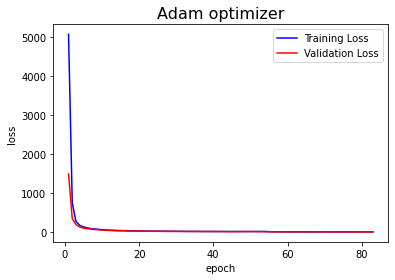

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

epoch = np.arange(1 , 84)

plt.title('Adam optimizer' , fontsize = 16)
plt.xlabel('epoch' , fontsize = 10)
plt.ylabel('loss' , fontsize = 10)

plt.plot(epoch , (freeze_hist.history['loss'] + unfreeze_hist.history['loss']) , color='b', label='Training Loss')
plt.plot(epoch , (freeze_hist.history['val_loss'] + unfreeze_hist.history['val_loss']) , color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [0]:
# 修正網路上抓取的圖片再存回去，其他修改以此類推
"""
yolo.py可以發現，其實不用reshape成(416,416,3)
"""
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('test/raccoon_1.PNG' , cv2.IMREAD_COLOR)
image = cv2.resize(image , (416 , 416))
print(image.shape)
cv2_imshow(image)
cv2.imwrite('test/1.PNG' , image)

In [0]:
# 可能碰到問題
# error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize' site:stackoverflow.com
# 解法：不要用for loop

In [0]:
log_dir = 'logs/1587467811/'
classes_path = 'class.txt'  # used only for constructing model

logs/1587467811/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (217, 24) (406, 493)
2.74088678499902


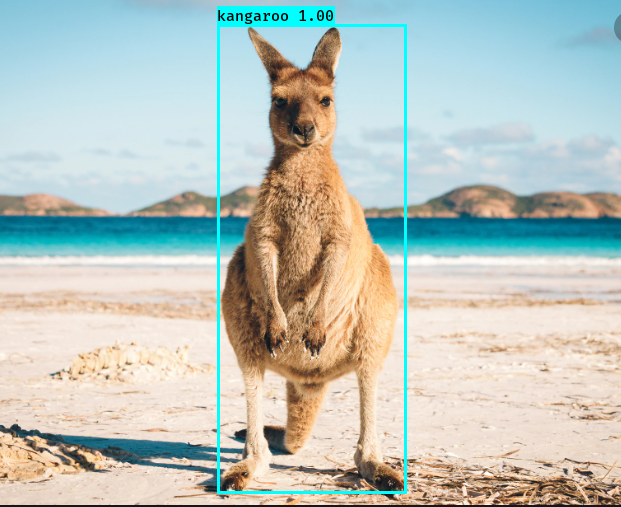

In [16]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

r_image = yolo_model.detect_image(Image.open('test/img/3.PNG'))  
display(r_image)

In [0]:
for i in range(1 , 4):
    r_image = yolo_model.detect_image(Image.open('test/' + str(i) + '.PNG'))  
    display(r_image)

In [0]:
from yolo import YOLO
import cv2
from tqdm import tqdm
from PIL import Image

log_dir = 'logs/1587467811/'
classes_path = 'class.txt'
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)


def detect_video(video_name):
  VIDEO_DATA_PATH = 'video'

  video_inp =  os.path.join(VIDEO_DATA_PATH , video_name)

  video_name_split = video_name.split('.')[0]

  # 偵測結果的輸出影像檔
  ########################
  video_out =  os.path.join(VIDEO_DATA_PATH,  video_name_split + "_out.mp4")

  # 透過OpenCv擷取影像
  video_reader = cv2.VideoCapture(video_inp)

  # 異常處理
  if not video_reader.isOpened(): 
    print(f'could not open : {video_inp}')
    return
  
  else:
    print('Open successfully!')

  # 取得影像的基本資訊
  # CAP_PROP:VideoCapture properties
  number_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # 總共有多少frames
  frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))  # 每個frame的高
  frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))   # 每個frame的寬
  video_fps = video_reader.get(cv2.CAP_PROP_FPS) 

  # 設定影像的輸出
  # codec:找影片編碼（例如:MPEG4編碼、H264編碼）
  # codec = int(video_reader.get(cv2.CAP_PROP_FOURCC))
  video_FourCC = cv2.VideoWriter_fourcc(*'MP4V')
  
  video_writer = cv2.VideoWriter(video_out , video_FourCC , video_fps , (frame_w, frame_h))

  # 迭代每一個frame來進行圖像偵測
  for i in tqdm(range(number_frames)):
    # Grabs, decodes and returns the next video frame.
    # returns a tuple (return value, image). 
    # With the first item check whether the reading was successful, and if it was then proceeds to use the returned image.
    # 參考： https://stackoverflow.com/questions/13989627/cv2-videocapture-read-does-not-return-a-numpy-array
    return_value , frame = video_reader.read() # 讀取一個frame
    
    # print(frame.shape) 416,416,3
    if return_value == True:
      
      """
      其實不用修改，詳情請trace yolo.py
      input_image = cv2.resize(frame, (416, 416)) # 修改輸入圖像大小來符合模型的要求

      if(input_image.shape[2] == 1):
        input_image = cv2.cvtColor(input_image , cv2.COLOR_GRAY2RGB)
      elif(input_image.shape[2] == 4):
        input_image = cv2.cvtColor(input_image , cv2.COLOR_RGBA2RGB)
      """
      #image = Image.fromarray(input_image)
      image = Image.fromarray(frame)
      result_image = yolo_model.detect_image(image)
      #############################################
      # 沒加上此行會報錯：Expected Ptr<cv::UMat> for argument '%s'
      result_image = np.asarray(result_image).astype('uint8')
      #############################################
      video_writer.write(result_image)
    else:
      break

  video_reader.release() # 釋放資源
  video_writer.release() # 釋放資源

logs/1587467811/trained_weights_final.h5 model, anchors, and classes loaded.


In [0]:
detect_video(video_name="Kangaroo.mp4")

In [0]:
# 進階目標，使用LabelImg創造自己的test data
# 將data寫到test.txt
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  sets=['test']

  
  classes = ["kangaroo" , "raccoon"]
  images_dir = ['test/img']

  def convert_annotation(data_path, list_file):
    in_file = open(data_path)
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
      difficult = obj.find('difficult').text
      cls = obj.find('name').text
          
      #如果類別不是對應在我們預定好的class文件中，或difficult==1則跳過
      if cls not in classes or int(difficult)==1:
        continue
      cls_id = classes.index(cls)
      xmlbox = obj.find('bndbox')
      b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
      list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))    
      
    in_file.close()
  
  for set in sets:
  
      list_file = open('%s.txt' % set , 'w')

      for  i , annotation_path in enumerate(['test/XML']):
        if os.path.exists(annotation_path):
          print('exists!')
        else:
          print('path not exist')

        # os.listdir() 方法用於返回指定的文件夾包含的文件或文件夾的名字的列表。
        annots = os.listdir(annotation_path)
        print(annots)
        #會按照xml的檔案名稱編號排序
        annots.sort()
        data = annots[:]
        print(data)

        for id in data: 
          # 例如：在kangaroo中data是00001.jpg，name則是00001
          name = id.split('.')[0]
          list_file.write(os.path.join(images_dir[i], '%s.PNG' % name))
          convert_annotation(os.path.join(annotation_path , id), list_file)
          list_file.write('\n')
        
      list_file.close()

In [0]:
# mAP介紹
# ref:https://medium.com/@chih.sheng.huang821/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92%E7%B3%BB%E5%88%97-%E4%BB%80%E9%BA%BC%E6%98%AFap-map-aaf089920848
# ref:https://github.com/Cartucho/mAP
# ref:https://www.pythonf.cn/read/23845

# 將預測結果寫成result.txt

# 創建一個存儲檢測結果的dir
result_path = 'test/result'

if not os.path.exists(result_path):
    print('result_path not exists')

# result如果之前存放的有文件，全部清除
for i in os.listdir(result_path):
    path_file = os.path.join(result_path, i)
    if os.path.isfile(path_file):
        os.remove(path_file)

# 創建一個紀錄檢測結果的文件
txt_path = result_path + '/result.txt'
file = open(txt_path, 'w')

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model


class YOLO(object):
    _defaults = {
        "model_path": 'logs/1587467811/trained_weights_final.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'class.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))

            ###################################################################
            file.write(predicted_class + ' ' + str(score) + ' ' + str(left) + ' ' + str(top) + ' ' + str(right) + ' ' + str(bottom) + ';')
            ###################################################################
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()

with open("test.txt", 'r') as f:  # 打開文件
  test_list = f.readlines()  # 讀取文件
  # https://stackoverflow.com/questions/45019304/what-value-does-readline-return-when-reaching-the-end-of-the-file-in-python
  test_list = [x.strip() for x in test_list if x.strip() != '']  # 去除/n     

yolo = YOLO()

for fileId in test_list:
        # 將原本名稱變為test/img/1.PNG
        image_path = fileId.split(' ')[0]
        # os.path.split()函數將文件路徑和文件名分開
        # 取得檔名:1
        portion = os.path.split(image_path)[1].split('.')[0]   
        file.write(image_path + ' ')
        image = Image.open(image_path)
        image_mAP_save_path = 'mAP/input/images-optional/'
        image.save(image_mAP_save_path + portion + '.PNG')
        r_image = yolo.detect_image(image)
        file.write('\n')
        #r_image.show() 顯示檢測結果
        image_save_path = 'test/result/img/result_'+portion + '.PNG'
        print('detect result save to....:'+image_save_path)
        r_image.save(image_save_path)

file.close()
yolo.close_session()

In [0]:
import re

with open('test/result/result.txt', 'r') as f:  # 打開文件
    filename = f.readlines()  # 讀取文件

for i in range(len(filename)):
    filename[i] = re.sub('test/img/','',filename[i])        # 去除文件名多餘的部分

for i in range(len(filename)): 
    r = filename[i].split('.PNG ')
    file = open('mAP/input/detection-results/' + r[0] + '.txt', 'w')
    t = r[1].split(';')
    print(t)


    # 去除換行
    t.remove('\n')
    print(t)
    if len(t) == 0:            # 如果沒有對象
        file.write('')
    else:
        for k in range(len(t)):
            file.write(t[k] + '\n')

In [0]:
import re

with open('test.txt', 'r') as f:  # 打開文件
    filename = f.readlines()  # 讀取文件


for i in range(len(filename)):
    filename[i] = re.sub('test/img/', '', filename[i])    # 去除文件名多余的部分

for i in range(len(filename)): 
    r = filename[i].split('.PNG ')
    file = open('mAP/input/ground-truth/' + r[0] + '.txt', 'w')
    t = r[1].split(' ')

    for j in range(len(t)):
        class_t = t[j].split(',')[-1]
        pos_t = t[j].split(',')
        if class_t == '0' or class_t == '0\n':
            file.write('kangaroo ' + pos_t[0] + ' ' + pos_t[1] + ' '+ pos_t[2] + ' '+ pos_t[3] + '\n')
        elif class_t == '1' or class_t == '1\n':
            file.write('raccoon ' + pos_t[0] + ' ' + pos_t[1] + ' '+ pos_t[2] + ' '+ pos_t[3] + '\n')

In [0]:
# 執行main.py
%cd mAP

In [10]:
# 問題:https://stackoverflow.com/questions/54577083/cannot-connect-to-x-server-google-colab
# 來源:https://www.pythonf.cn/read/23845
!python3 main.py

DR_path /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/detection-results
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/1
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/10
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/11
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/12
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/13
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/14
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/15
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/16
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/2
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/3
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP/input/ground-truth/4
file_id /content/drive/My Drive/cv/day39/keras-yolo3/m

In [11]:
%cd ..

/content/drive/My Drive/cv/day39/keras-yolo3


In [34]:
# 進階目標:iou計算
def iou(box1, box2):
    """
    Implement the intersection over union (IoU) between box1 and box2
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (yi2 - yi1) * (xi2 - xi1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    # compute the IoU
    iou = inter_area / union_area

    return iou

iou_list = []

# 挑幾個圖片計算iou
for i in range(4 , 10):  
  with open(f'mAP/input/ground-truth/{i}.txt') as f:
    content = f.readlines()
    if(len(content) == 1):  #如果只有一個bounding box
      content = content[0].strip()
      content = content.split()[1:]
      content = list(int(x) for x in content )
      box1 = content[0:]
  
  with open(f'mAP/input/detection-results/{i}.txt') as f:
    pcontent = f.readlines()
    if(len(pcontent) == 1):  #如果只有一個bounding box
      pcontent = pcontent[0].strip()
      pcontent = pcontent.split()[2:]
      pcontent = list(int(x) for x in pcontent )
      box2 = pcontent[0:]
  
  
  iou_return = iou(box1 , box2)

  iou_list.append(iou_return) 

print(iou_list)

[0.6310204207729618, 0.8873482618330962, 0.8881560830533678, 0.741249204144238, 0.7803084223013048, 0.7803084223013048]


In [0]:
# 進階目標:使用augmentation
# ref:https://blog.paperspace.com/data-augmentation-for-bounding-boxes/
import numpy as np
import random

class RandomHorizontalFlip(object):
    
    """Randomly horizontally flips the Image with the probability *p*
    
    Parameters
    ----------
    p: float
        The probability with which the image is flipped
    ----------
    Returns 
    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
    """
    def __init__(self, p=1):
        self.p = p
    def __call__(self, img, bboxes):
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))
        if random.random() < self.p:
            img =  img[:,::-1,:]
            bboxes[:,[0,2]] += 2*(img_center[[0,2]] - bboxes[:,[0,2]])
            
            box_w = abs(bboxes[:,0] - bboxes[:,2])
             
            bboxes[:,0] -= box_w
            bboxes[:,2] += box_w
            
        return img, bboxes
rh = RandomHorizontalFlip()

In [0]:
# ref:https://stackoverflow.com/questions/1767513/read-first-n-lines-of-a-file-in-python
# ref:https://stackoverflow.com/questions/902761/saving-a-numpy-array-as-an-image
# 要把numpy array存成圖片需要Image.formarray()

# augment for kangaroo

import numpy as np
from google.colab.patches import  cv2_imshow
from PIL import Image

with open('train.txt' , 'r') as f:
  head = [next(f) for x in range(20)]

print(head)
head = [x.strip() for x in head]
path = [x.split()[0] for x in head]


bboxes =[]
temp_list = []
class_label = []

for i in range(len(head)):
  temp = head[i].split(' ')[1:]
  for x in temp:
    bbox = x.split(',')[:-1]
    c = x.split(',')[-1]
    class_label.append(c)
    for item in bbox:
      temp_list.append(float(item))
  bboxes.append(temp_list)
  temp_list=[]

print(path)
#print(bboxes)
print(class_label)

kangaroo_img_path = 'kangaroo-master/images/'
raccoon_img_path = 'raccoon_dataset-master/images/'

counter = 0

with open('aug_train.txt' , 'a') as aug_file:
  for i in range(len(bboxes)):
    print(path[i])
    np_bbox = np.array(bboxes[i])
    np_bbox = np_bbox.reshape(-1,4)
    print(np_bbox)
    img = Image.open(path[i])
    img = np.array(img)
    re_img , re_bbox = rh(img,np_bbox)
    print(re_bbox)
    ##################################
    counter = 0
    ##################################
    if(class_label[i] == '0'):
      re_img = Image.fromarray(re_img)
      re_img.save(kangaroo_img_path + f'00{184 + i }' + '.jpg' )
      aug_file.write(kangaroo_img_path + f'00{184 + i }' + '.jpg ')
      for j in re_bbox:
        for k in j:
          k = k.astype(int)
          aug_file.write(f'{k},')
        if(counter != len(list(re_bbox))-1):
          aug_file.write(f'{class_label[i]} ')
        else:
          aug_file.write(f'{class_label[i]}')
        counter +=1
      aug_file.write('\n')

    elif(class_label[i] == '1'):
      re_img = Image.fromarray(re_img)
      re_img.save(raccoon_img_path + f'raccoon-{201 + i }' + '.jpg' )
      aug_file.write(raccoon_img_path + f'raccoon-{201 + i }' + '.jpg ')
      for j in re_bbox:
        for k in j:
          k = k.astype(int)
          aug_file.write(f'{k},')
        if(counter != len(list(re_bbox))-1):
          aug_file.write(f'{class_label[i]} ')
        else:
          aug_file.write(f'{class_label[i]}')
        counter +=1
      aug_file.write('\n')

    #cv2_imshow(re_img)

In [0]:
# 參考:https://thispointer.com/python-get-last-n-lines-of-a-text-file-like-tail-command/
# 讀取最後N行
import os
 
def get_last_n_lines(file_name, N):
    # Create an empty list to keep the track of last N lines
    list_of_lines = []
    # Open file for reading in binary mode
    with open(file_name, 'rb') as read_obj:
        # Move the cursor to the end of the file
        read_obj.seek(0, os.SEEK_END)
        # Create a buffer to keep the last read line
        buffer = bytearray()
        # Get the current position of pointer i.e eof
        pointer_location = read_obj.tell()
        # Loop till pointer reaches the top of the file
        while pointer_location >= 0:
            # Move the file pointer to the location pointed by pointer_location
            read_obj.seek(pointer_location)
            # Shift pointer location by -1
            pointer_location = pointer_location -1
            # read that byte / character
            new_byte = read_obj.read(1)
            # If the read byte is new line character then it means one line is read
            if new_byte == b'\n':
                # Save the line in list of lines
                list_of_lines.append(buffer.decode()[::-1])
                # If the size of list reaches N, then return the reversed list
                if len(list_of_lines) == N:
                    return list(reversed(list_of_lines))
                # Reinitialize the byte array to save next line
                buffer = bytearray()
            else:
                # If last read character is not eol then add it in buffer
                buffer.extend(new_byte)
 
        # As file is read completely, if there is still data in buffer, then its first line.
        if len(buffer) > 0:
            list_of_lines.append(buffer.decode()[::-1])
 
    # return the reversed list
    return list(reversed(list_of_lines))

In [0]:
# ref:https://stackoverflow.com/questions/1767513/read-first-n-lines-of-a-file-in-python
# ref:https://stackoverflow.com/questions/902761/saving-a-numpy-array-as-an-image
# 要把numpy array存成圖片需要Image.formarray()

# augment for raccoon

import numpy as np
from google.colab.patches import  cv2_imshow
from PIL import Image

# Get last ten lines from file 'sample.txt'
last_lines = get_last_n_lines("train.txt", 20)[0:-1]

print(last_lines)
last_lines = [x.strip() for x in last_lines]
path = [x.split()[0] for x in last_lines]

bboxes =[]
temp_list = []
class_label = []

for i in range(len(last_lines)):
  temp = last_lines[i].split(' ')[1:]
  for x in temp:
    bbox = x.split(',')[:-1]
    c = x.split(',')[-1]
    class_label.append(c)
    for item in bbox:
      temp_list.append(float(item))
  bboxes.append(temp_list)
  temp_list=[]

print(path)
#print(bboxes)
print(class_label)

kangaroo_img_path = 'kangaroo-master/images/'
raccoon_img_path = 'raccoon_dataset-master/images/'

counter = 0

with open('aug_train.txt' , 'a') as aug_file:
  for i in range(len(bboxes)):
    print(path[i])
    np_bbox = np.array(bboxes[i])
    np_bbox = np_bbox.reshape(-1,4)
    print(np_bbox)
    img = Image.open(path[i])
    img = np.array(img)
    re_img , re_bbox = rh(img,np_bbox)
    print(re_bbox)
    ##################################
    counter = 0
    ##################################
    if(class_label[i] == '0'):
      re_img = Image.fromarray(re_img)
      re_img.save(kangaroo_img_path + f'00{184 + i }' + '.jpg' )
      aug_file.write(kangaroo_img_path + f'00{184 + i }' + '.jpg ')
      for j in re_bbox:
        for k in j:
          k = k.astype(int)
          aug_file.write(f'{k},')
        if(counter != len(list(re_bbox))-1):
          aug_file.write(f'{class_label[i]} ')
        else:
          aug_file.write(f'{class_label[i]}')
        counter +=1
      aug_file.write('\n')

    elif(class_label[i] == '1'):
      re_img = Image.fromarray(re_img)
      re_img.save(raccoon_img_path + f'raccoon-{201 + i }' + '.jpg' )
      aug_file.write(raccoon_img_path + f'raccoon-{201 + i }' + '.jpg ')
      for j in re_bbox:
        for k in j:
          k = k.astype(int)
          aug_file.write(f'{k},')
        if(counter != len(list(re_bbox))-1):
          aug_file.write(f'{class_label[i]} ')
        else:
          aug_file.write(f'{class_label[i]}')
        counter +=1
      aug_file.write('\n')

    #cv2_imshow(re_img)

In [8]:
# 重新train
annotation_path_train = 'aug_train.txt' # 轉換好格式的 train 標註檔案
annotation_path_val = 'val.txt' # 轉換好格式的 val 標註檔案
log_dir = 'logs/%s/' % str(int(time.time())) # 訓練好的模型儲存的路徑
classes_path = 'class.txt'  # used only for constructing model
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)

#anchors是檢測框的尺寸；
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, (h , w) 

is_tiny_version =  len(anchors)==6 # default setting


# Freeze darknet53 body or freeze all but 3 output layers
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation

with open(annotation_path_train) as f:
    train_lines = f.readlines()
with open(annotation_path_val) as f:
    val_lines = f.readlines()

np.random.seed(10101)
np.random.shuffle(train_lines)
np.random.shuffle(val_lines)
np.random.seed(None)

num_val = len(val_lines)
num_train = len(train_lines)

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
# freeze的含義就是將該模型的圖結構和該模型的權重固化到一起了.也即加載freeze的模型之后,立刻能夠使用了。
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    freeze_hist = model.fit_generator(data_generator_wrapper(train_lines , batch_size, input_shape, anchors, num_classes),
            # steps_per_epoch is used to generate the entire dataset once by calling the generator steps_per_epoch times
            # https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(val_lines , batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=80,
            initial_epoch=0,
            callbacks=[logging, checkpoint , reduce_lr , early_stopping])
    model.save_weights(log_dir + 'aug_trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 8 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    unfreeze_hist = model.fit_generator(data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(val_lines, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'aug_trained_weights_final.h5')














Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 367 samples, val on 36 samples, with batch size 16.




Epoch 1/80
22/22 [==============================] - 113s 5s/step - loss: 4508.3645 - val_loss: 1041.8658

Epoch 2/80
22/22 [==============================] - 25s 1s/step - loss: 581.6971 - val_loss: 285.2435
Epoch 3/80
22/22 [==============================] - 25s 1s/step - loss: 247.8436 - val_loss: 173.4463
Epoch 4/80
22/22 [==============================] - 24s 1s/step - loss: 171.6684 - val_loss: 131.7582
Epoch 5/80
22/22 [==============================] - 25s 1s/step - loss: 135.3398 - val_loss: 107.3561
Epoch 6/80
22/22 [==============================] - 25s 1s/step - loss: 111.3061 - val_loss: 91.6043
Epoch 7/80
22/22 [==============================] - 24s 1s/step - loss: 95.7721 - val_loss: 77.9422
Epoch 8/80
22/22 [================

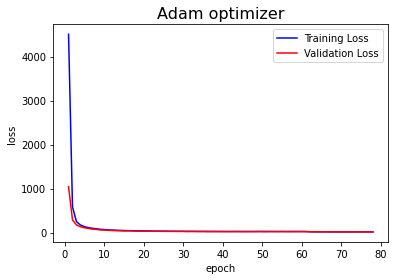

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

epoch = np.arange(1 , 79)

plt.title('Adam optimizer' , fontsize = 16)
plt.xlabel('epoch' , fontsize = 10)
plt.ylabel('loss' , fontsize = 10)

plt.plot(epoch , (freeze_hist.history['loss'] + unfreeze_hist.history['loss']) , color='b', label='Training Loss')
plt.plot(epoch , (freeze_hist.history['val_loss'] + unfreeze_hist.history['val_loss']) , color='r', label='Validation Loss')
plt.legend(loc='upper right')

logs/1588905358/aug_trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (209, 3) (409, 507)
2.637918066999191


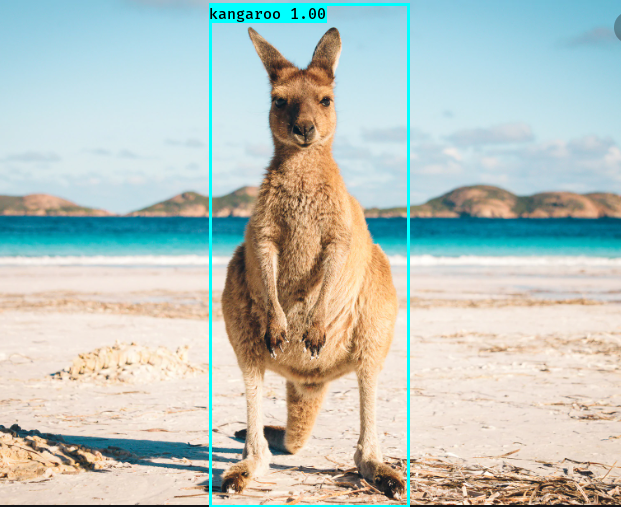

In [14]:
from yolo import YOLO
from PIL import Image
yolo_model = YOLO(model_path=log_dir + 'aug_trained_weights_final.h5', classes_path=classes_path)

r_image = yolo_model.detect_image(Image.open('test/img/3.PNG'))  
display(r_image)

In [7]:
import os
#mAP-with-augmentation

# 將預測結果寫成aug_result.txt

# 創建一個存儲檢測結果的dir
result_path = 'test/result'

if not os.path.exists(result_path):
    print('result_path not exists')


# 創建一個紀錄檢測結果的文件
txt_path = result_path + '/aug_result.txt'
file = open(txt_path, 'w')

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model


class YOLO(object):
    _defaults = {
        "model_path": 'logs/1588905358/aug_trained_weights_final.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'class.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))

            ###################################################################
            file.write(predicted_class + ' ' + str(score) + ' ' + str(left) + ' ' + str(top) + ' ' + str(right) + ' ' + str(bottom) + ';')
            ###################################################################
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()

with open("test.txt", 'r') as f:  # 打開文件
  test_list = f.readlines()  # 讀取文件
  # https://stackoverflow.com/questions/45019304/what-value-does-readline-return-when-reaching-the-end-of-the-file-in-python
  test_list = [x.strip() for x in test_list if x.strip() != '']  # 去除/n     

yolo = YOLO()

for fileId in test_list:
        # 將原本名稱變為test/img/1.PNG
        image_path = fileId.split(' ')[0]
        # os.path.split()函數將文件路徑和文件名分開
        # 取得檔名:1
        portion = os.path.split(image_path)[1].split('.')[0]   
        file.write(image_path + ' ')
        image = Image.open(image_path)
        image_mAP_save_path = 'mAP_with_aug/input/images-optional/'
        image.save(image_mAP_save_path + portion + '.PNG')
        r_image = yolo.detect_image(image)
        file.write('\n')
        #r_image.show() 顯示檢測結果
        image_save_path = 'test/result/aug_img/result_'+portion + '.PNG'
        print('detect result save to....:'+image_save_path)
        r_image.save(image_save_path)

file.close()
yolo.close_session()













logs/1588905358/aug_trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (147, 5) (606, 370)
7.805939868999985
detect result save to....:test/result/aug_img/result_1.PNG
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (64, 82) (599, 538)
0.11532366000005823
detect result save to....:test/result/aug_img/result_10.PNG
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (51, 32) (604, 377)
0.12700582299999041
detect result save to....:test/result/aug_img/result_11.PNG
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (47, 64) (361, 649)
0.128674042999819
detect result save to....:test/result/aug_img/result_12.PNG
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (149, 133) (302, 359)
kangaroo 1.00 (309, 72) (554, 437)
0.13064096400012204
detect result save to....:test/result/aug_img/result_13.PNG
(416, 416, 3)
Found 1 boxes for 

In [8]:
import re

with open('test/result/aug_result.txt', 'r') as f:  # 打開文件
    filename = f.readlines()  # 讀取文件

for i in range(len(filename)):
    filename[i] = re.sub('test/img/','',filename[i])        # 去除文件名多餘的部分

for i in range(len(filename)): 
    r = filename[i].split('.PNG ')
    file = open('mAP_with_aug/input/detection-results/' + r[0] + '.txt', 'w')
    t = r[1].split(';')
    print(t)


    # 去除換行
    t.remove('\n')
    print(t)
    if len(t) == 0:            # 如果沒有對象
        file.write('')
    else:
        for k in range(len(t)):
            file.write(t[k] + '\n')

['kangaroo 0.996677 147 5 606 370', '\n']
['kangaroo 0.996677 147 5 606 370']
['raccoon 0.9947471 64 82 599 538', '\n']
['raccoon 0.9947471 64 82 599 538']
['kangaroo 0.99884975 51 32 604 377', '\n']
['kangaroo 0.99884975 51 32 604 377']
['kangaroo 0.970795 47 64 361 649', '\n']
['kangaroo 0.970795 47 64 361 649']
['kangaroo 0.33623287 149 133 302 359', 'kangaroo 0.9988717 309 72 554 437', '\n']
['kangaroo 0.33623287 149 133 302 359', 'kangaroo 0.9988717 309 72 554 437']
['raccoon 0.998814 69 17 682 352', '\n']
['raccoon 0.998814 69 17 682 352']
['raccoon 0.9864121 211 51 548 482', '\n']
['raccoon 0.9864121 211 51 548 482']
['raccoon 0.9915491 362 0 722 458', '\n']
['raccoon 0.9915491 362 0 722 458']
['kangaroo 0.9991979 338 26 578 406', '\n']
['kangaroo 0.9991979 338 26 578 406']
['kangaroo 0.99841946 209 3 409 507', '\n']
['kangaroo 0.99841946 209 3 409 507']
['kangaroo 0.98779 111 126 519 419', '\n']
['kangaroo 0.98779 111 126 519 419']
['raccoon 0.9836614 147 9 929 574', '\n']
['ra

In [0]:
import re

with open('test.txt', 'r') as f:  # 打開文件
    filename = f.readlines()  # 讀取文件


for i in range(len(filename)):
    filename[i] = re.sub('test/img/', '', filename[i])    # 去除文件名多余的部分

for i in range(len(filename)): 
    r = filename[i].split('.PNG ')
    file = open('mAP_with_aug/input/ground-truth/' + r[0] + '.txt', 'w')
    t = r[1].split(' ')

    for j in range(len(t)):
        class_t = t[j].split(',')[-1]
        pos_t = t[j].split(',')
        if class_t == '0' or class_t == '0\n':
            file.write('kangaroo ' + pos_t[0] + ' ' + pos_t[1] + ' '+ pos_t[2] + ' '+ pos_t[3] + '\n')
        elif class_t == '1' or class_t == '1\n':
            file.write('raccoon ' + pos_t[0] + ' ' + pos_t[1] + ' '+ pos_t[2] + ' '+ pos_t[3] + '\n')

In [10]:
# 執行main.py
%cd mAP_with_aug

/content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug


In [11]:
!python3 main.py

DR_path /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/detection-results
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/ground-truth/1
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/ground-truth/10
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/ground-truth/11
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/ground-truth/12
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/ground-truth/13
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/ground-truth/14
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/ground-truth/15
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/ground-truth/16
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/ground-truth/2
file_id /content/drive/My Drive/cv/day39/keras-yolo3/mAP_with_aug/input/ground-truth/3
file_id /content/drive/My Drive/c

In [12]:
%cd ..

/content/drive/My Drive/cv/day39/keras-yolo3


In [13]:
# 進階目標:iou計算
def iou(box1, box2):
    """
    Implement the intersection over union (IoU) between box1 and box2
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (yi2 - yi1) * (xi2 - xi1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    # compute the IoU
    iou = inter_area / union_area

    return iou

iou_list = []

# 挑幾個圖片計算iou
for i in range(4 , 10):  
  with open(f'mAP_with_aug/input/ground-truth/{i}.txt') as f:
    content = f.readlines()
    if(len(content) == 1):  #如果只有一個bounding box
      content = content[0].strip()
      content = content.split()[1:]
      content = list(int(x) for x in content )
      box1 = content[0:]
  
  with open(f'mAP_with_aug/input/detection-results/{i}.txt') as f:
    pcontent = f.readlines()
    if(len(pcontent) == 1):  #如果只有一個bounding box
      pcontent = pcontent[0].strip()
      pcontent = pcontent.split()[2:]
      pcontent = list(int(x) for x in pcontent )
      box2 = pcontent[0:]
  
  
  iou_return = iou(box1 , box2)

  iou_list.append(iou_return) 

print(iou_list)

[0.8318042813455657, 0.8211150706691006, 0.7702089552238806, 0.7800770995435518, 0.8784896336209134, 0.44343285580398983]
